In [6]:
import numpy as np
import pandas

# A executer pour que les widgets fonctionnent: "jupyter labextension install @jupyter-widgets/jupyterlab-manager" pour jupyterlab
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Téléchargement des données de tests par département
data = pandas.read_csv("https://www.data.gouv.fr/fr/datasets/r/406c6a23-e283-4300-9484-54e78c8ae675",
               sep = ';', 
               dtype = {'dep':np.str, 'P':np.int32,'T':np.int32,'cl_age90':np.int32},
                parse_dates = ['jour']
               )

In [7]:
# Sélection du département
def g(dept):
    return dept
deptWidget = interactive(g, dept=data.dep.unique());
display(deptWidget)

interactive(children=(Dropdown(description='dept', options=('01', '02', '03', '04', '05', '06', '07', '08', '0…

In [8]:
dept = deptWidget.result
print("Affichage pour le département " + dept)
deptData = data.loc[data['dep'] == dept]

testedDeptAllAges = deptData.groupby(['jour'])['T'].sum()
positifDeptAllAges = deptData.groupby(['jour'])['P'].sum()


Affichage pour le département 38


In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

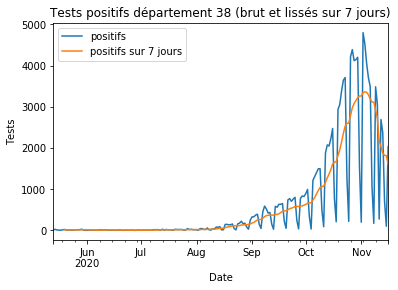

In [11]:
# Tests positifs
# Sélection de la période la plus récente (ex: 60 derniers jours)
positifDeptAllAges2 = positifDeptAllAges#[-60:-1]
# Graphique
positifDeptAllAges2.plot(x='jour', y='P', label='positifs')
# Moyennage sur 7 jours glissants pour lisser l'absence de tests le dimanche
positifDeptAllAges2.rolling(7).mean().plot(x='jour', label='positifs sur 7 jours')
# Légende
plt.legend()
plt.title("Tests positifs département " + dept + " (brut et lissés sur 7 jours)")
plt.xlabel("Date")
plt.ylabel("Tests")
plt.show()

In [12]:
# Afficher les chiffres bruts des 10 derniers jours
print(positifDeptAllAges2[-10:])

jour
2020-11-07    1052
2020-11-08     168
2020-11-09    3486
2020-11-10    3062
2020-11-11     272
2020-11-12    2691
2020-11-13    2371
2020-11-14     702
2020-11-15      98
2020-11-16    2032
Name: P, dtype: int32


In [13]:
# Date des dernières données (en général quelques jours en arrière, données consolidées)
print("Dernières données du " + str(data.jour.unique()[-1])[:10])

Dernières données du 2020-11-16


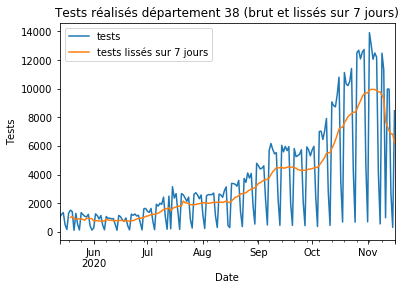

In [15]:
# Nombre de tests réalisés
testedDeptAllAges.plot(x='jour', y='T', label='tests')
testedDeptAllAges.rolling(7).mean().plot(x='jour', label='tests lissés sur 7 jours')
plt.legend()
plt.title("Tests réalisés département " + dept + " (brut et lissés sur 7 jours)")
plt.xlabel("Date")
plt.ylabel("Tests")
#data.plot(x='jour', y='T')#, ylabel='testés')
#data.plot(x='jour', y='P')#, ylabel='positifs')
plt.show()


In [17]:
# Code EPCI des métropoles - sélection d'une 'métropole
metros = pandas.read_csv("https://www.data.gouv.fr/fr/datasets/r/0fa52fca-4eb3-4786-92f1-6db24273068f",
               sep = ';', 
               encoding = "ISO-8859-15",
               dtype = {'EPCI':np.str, 'Metropole':np.str},
        )
metros = list(metros.itertuples(index=False, name=None))
metros2 = [m[::-1] for m in metros]

def f(metropole):
    return(metropole)

metroWidget = interactive(f, metropole=metros2);
display(metroWidget)

interactive(children=(Dropdown(description='metropole', options=(('Bordeaux', '243300316'), ('Brest', '2429003…

In [18]:
metroEPCI = metroWidget.result
print("Affichage des données pour la métropole de "+[metro[1] for metro in metros if metro[0] == metroEPCI][0])

Affichage des données pour la métropole de Grenoble


In [19]:
# Lecture des données COVID par métropole
dataMetros = pandas.read_csv("https://www.data.gouv.fr/fr/datasets/r/61533034-0f2f-4b16-9a6d-28ffabb33a02",
               sep = ';', 
               dtype = {'epci2020':np.str, 'ti':np.float64,'clage_65':np.int32, 'semaine_glissante':np.str},
                #parse_dates = ['semaine_glissante']
               )

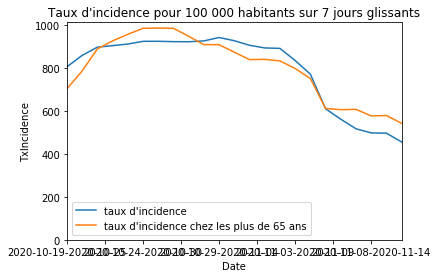

In [21]:
metropole = dataMetros[dataMetros.epci2020 == metroEPCI]
metropoleSorted = metropole.sort_values("semaine_glissante")
metropoleAll = metropoleSorted[metropoleSorted.clage_65 == 0]
#print(metropoleAll)
metropolePlus65 = metropoleSorted[metropoleSorted.clage_65 != 0]
#print(metropolePlus65)
ax = metropoleAll.plot(x='semaine_glissante', y='ti', label='taux d\'incidence')
metropolePlus65.plot(x='semaine_glissante', y='ti', label='taux d\'incidence chez les plus de 65 ans', ax=ax)

plt.legend()
plt.title("Taux d'incidence pour 100 000 habitants sur 7 jours glissants")
plt.xlabel("Date")
plt.ylabel("TxIncidence")
ax.set_ylim(bottom=0)
plt.show()

In [22]:
# Données par quartier : Code localisation 381850210	Ile Verte-Maréchal Randon, cf https://www.data.gouv.fr/fr/datasets/donnees-de-laboratoires-infra-departementales-durant-lepidemie-covid-19/
# Afficher une carte avec ipyleaflet
# Ajouter les contours IRIS sélectionnables https://geoservices.ign.fr/documentation/diffusion/telechargement-donnees-libres.html au format shapefile
# Récupérer les données (135 Mo à télécharger !)
# Afficher celles de la zone choisie